In [33]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import cross_val_score

In [34]:
# Reset pseudo random number generator so that the results are reproducible.
seed = 42
np.random.seed(seed)

### Generating the target function and its noisy version.

Geramos 30 amostras da seguinte função objetivo

$$y = 1 + 0.5 x + 2 x^2$$

In [35]:
# Sets the number of examples.
N = 30

# Attribute.
x = np.sort(2*np.random.rand(N, 1) - 1, axis=0)

# Target function.
y = 1 + 0.5*x + 2*x**2

# Noise.
w = np.sqrt(0.09)*np.random.randn(N, 1)

# Noisy function.
y_noisy = y + w

In [36]:
print('Média das amostras da função observável:', np.mean(y_noisy))

Média das amostras da função observável: 1.530915117847102


**Observação**

+ A média de $y_{noisy}$ é igual a $1.531$, pois sua esperança é igual a $1 + 2 \big(\frac{1}{3}\big)$.


+ Isso de deve ao fato do atributo $x^2$ ter esperança igual a $\frac{1}{3}$ e o atributo $x$ e o ruído $w$ terem esperanças iguais a zero, respectivamente.

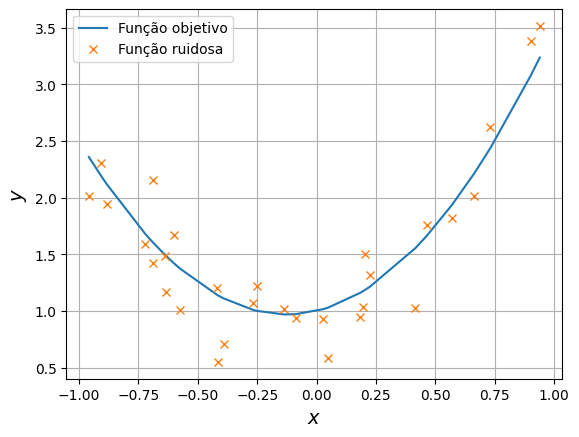

In [37]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Função objetivo')
plt.plot(x, y_noisy, 'x', label='Função ruidosa')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#Show the plot.
plt.show()

### Define the polinomial order

In [38]:
# Polynomial order.
model_order = 15

### Define the regularization factor

In [39]:
# Regularization factor.
lambdas = [0, 0.0192, 1, 10]

### Elastic-net with $\kappa$ = 0.5

Lambda: 0.0000e+00:
[1.53091512]
[[-3.26619148e-01  6.26027965e+00  9.11715885e+00 -8.93092859e+01
  -9.13730327e+01  5.26147653e+02  5.43742416e+02 -1.51291387e+03
  -1.71566113e+03  2.27078228e+03  2.80890380e+03 -1.70290215e+03
  -2.25122856e+03  5.02976634e+02  6.97684255e+02]]
---------------------------------------------
Lambda: 1.9200e-02:
[1.53091512]
[ 0.25359744  0.49235145  0.          0.13412997  0.          0.
  0.         -0.          0.         -0.          0.01728689 -0.
  0.03613996 -0.00058128  0.04815505]
---------------------------------------------
Lambda: 1.0000e+00:
[1.53091512]
[0.         0.0418062  0.         0.02146643 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
---------------------------------------------
Lambda: 1.0000e+01:
[1.53091512]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
---------------------------------------------


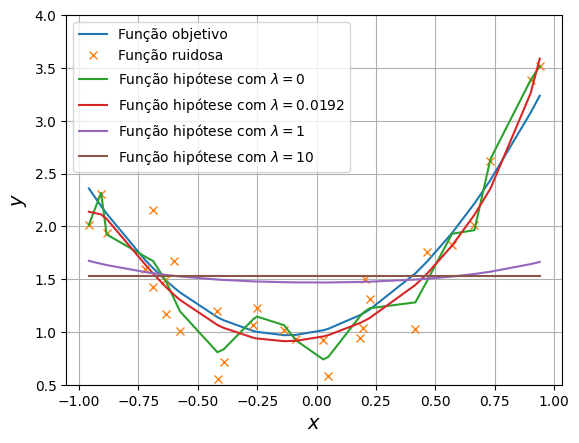

In [40]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Função objetivo')
plt.plot(x, y_noisy, 'x', label='Função ruidosa')
for i in range(0, len(lambdas)):

    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=model_order, include_bias=False)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()
    # Instantiate a ElasticNet regressor.
    reg = ElasticNet(alpha=lambdas[i], l1_ratio=0.5, random_state=seed) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)

    # Print coefs
    print('Lambda: %1.4e:' % (lambdas[i]))
    print(model.named_steps['reg'].intercept_)
    print(model.named_steps['reg'].coef_)
    print('---------------------------------------------')
    # Predict.
    y_test_regul = model.predict(x)
    # Plot prediction.
    plt.plot(x, y_test_regul, label='Função hipótese com $\lambda=$'+str(lambdas[i]))

plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.ylim(0.5,4)
#Show the plot.
plt.show()

### Weight variation versus lambda (i.e., regularization factor)

Cria uma sequência de 5000 valores linearmente espaçados para o fator de regularização, variando de $1e^{-5}$ até $1$.

Usaremos $\kappa$ = 0.5.

In [41]:
M = 5000
lambdas = np.linspace(1e-5, 1, M)

# Leave-one-out
lpocv = LeavePOut(p=1)

a_hist = np.zeros((model_order, M))
norm_hist = np.zeros((1, M))
error_test = []

for i in range(0,len(lambdas)):
    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=model_order, include_bias=False)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()
    # Instantiate a ElasticNet regressor.
    reg = ElasticNet(alpha=lambdas[i], l1_ratio=0.5, tol=1, random_state=seed) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    # Cross-validation
    lin_scores = cross_val_score(model, x, y_noisy, scoring='neg_mean_squared_error', cv=lpocv, n_jobs=-1)

    # Convert back to MSE by multiplying it by minus one.
    scores = -lin_scores
    # Mean of the MSE values, i.e., calculate ter MSE for each one of the folds.
    error_test.append(scores.mean())

    # Train model.
    model.fit(x, y_noisy)
    a = model.named_steps['reg'].coef_
    a_hist[:,i] = a
    norm_hist[:,i] = np.linalg.norm(a)

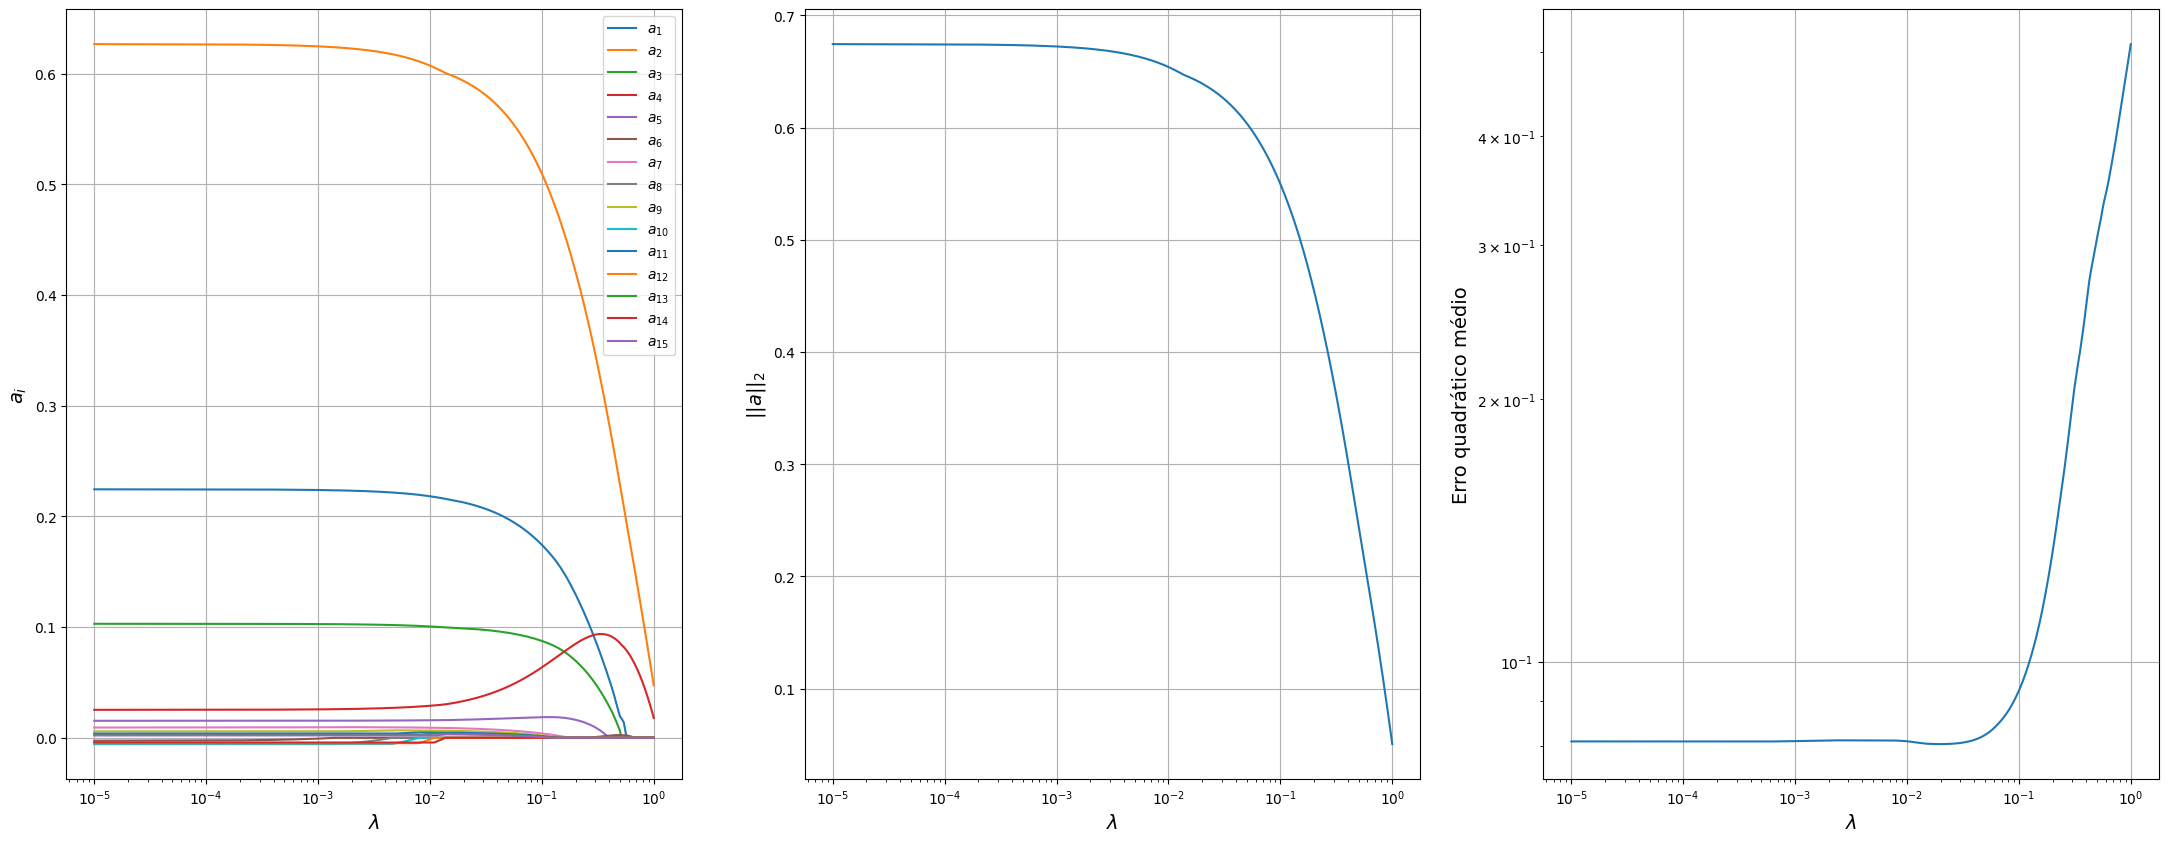

In [42]:
# Generate figure.
fig = plt.figure(figsize=(27,10))

# Plot weight.
ax = plt.subplot(1, 3, 1)
for i in range(0,model_order):
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$a_i$', fontsize=14)
plt.legend(loc='upper right')
plt.grid()

# Plot norm.
ax = plt.subplot(1, 3, 2)
plt.plot(lambdas, norm_hist[0,:])
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$||a||_2$', fontsize=14)
plt.grid()

# Plot error.
ax = plt.subplot(1, 3, 3)
plt.plot(lambdas, error_test)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('Erro quadrático médio', fontsize=14)
plt.grid()

#Show the plot.
plt.show()

### Obtendo o melhor $\lambda$.

In [43]:
# Obtém o índice com o menor erro.
min_idx = np.argmin(error_test)
print('idx: %d - MSE min: %f - best lambda: %f' % (min_idx, error_test[min_idx], lambdas[min_idx]))

idx: 96 - MSE min: 0.080420 - best lambda: 0.019214


### ElasticNet CV for finding the best $\lambda$


A classe `ElasticNetCV` pode ser usada para encontrar os parâmetros $\lambda$ e $\kappa$, fatores de regularização e de elasticidade, respectivamente, através de validação cruzada.


In [44]:
M = 5000

# List of elastic parameters.
l1_ratio = [.1, .5, .7, .9, .95, .99, 1]

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=False)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a ElasticNet regressor.
reg = ElasticNetCV(n_alphas=M, l1_ratio=l1_ratio, tol=1, random_state=seed, n_jobs=-1)
# Create a pipeline of actions.
clf = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

# Find the best alpha value.
clf.fit(x, y_noisy.ravel())

# Perform prediction.
y_test_pred = clf.predict(x)

#### Melhores valores encontrados.

In [45]:
clf['reg'].alpha_

0.006928524630565012

In [46]:
clf['reg'].l1_ratio_

1.0

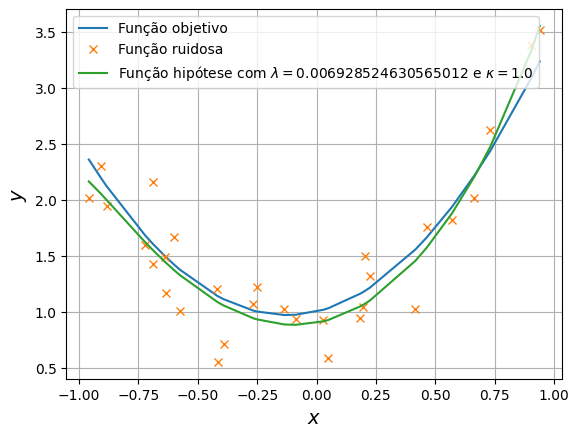

In [49]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Função objetivo')
plt.plot(x, y_noisy, 'x', label='Função ruidosa')
plt.plot(x, y_test_pred, label='Função hipótese com $\lambda=$'+str(clf['reg'].alpha_) + " e $\kappa=$"+str(clf['reg'].l1_ratio_))
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#Show the plot.
plt.show()

### Comparando os valores de $\lambda$ obtidos com a validação cruzada implementada de forma manual e com a classe `ElasticNetCV`

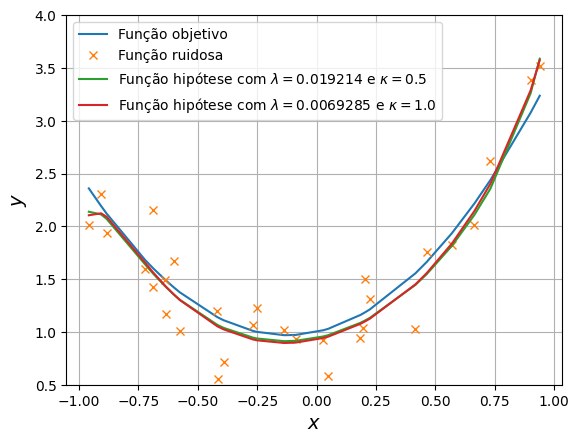

In [50]:
lambdas = [0.019214, 0.0069285]
l1_ratio = [0.5, 1.0]

# Plot original data versus noisy version.
plt.plot(x, y, label='Função objetivo')
plt.plot(x, y_noisy, 'x', label='Função ruidosa')
for i in range(0, len(lambdas)):

    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=model_order, include_bias=False)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()
    # Instantiate a ElasticNet regressor.
    reg = ElasticNet(alpha=lambdas[i], l1_ratio=l1_ratio[i], random_state=seed) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)

    # Predict.
    y_test_regul = model.predict(x)
    # Plot prediction.
    plt.plot(x, y_test_regul, label='Função hipótese com $\lambda=$'+str(lambdas[i])+" e $\kappa=$" + str(l1_ratio[i]))

plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.ylim(0.5,4)
#Show the plot.
plt.show()